# Communication Towers Problem

In this problem, there will be a space that towers will cover randomly one by one. As shown in the pdf on the class website, the problem is that the coverage, represented by rectangles, cannot overlap each other, and if a rectangle is initially overlapping another, it is trimmed so that it is a rectangle which covers the maximum area.

In my implementation of the solution to this problem, I broke it down in this fashion.

1. Create a generator function which outputs uniformally distributed rectangles.
2. Create a 2-D array that stores all the existing coverage on it.
3. Create a function that trims the rectangle so that it follows the rules and fits on the 2-D array specified above.
4. Plot the 2-D array in step 2 everytime it is updated for visualization.
5. Have a variation where we can input an integer n which specifies the number of communication towers to be mapped.

# Modules and Constants

I wanted to use numpy for easier matrix manipulation, making it easier to tackle this problem with matrices. I also imported modules to help with visualization. I set the global variable of the window size = 10 initially.

In [2]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt #visualization
import matplotlib.animation as animation #visualization

WINDOW_SIZE = 10
#10 square units but zero-indexed so index goes up to nine

# Rectangle Generator

Because the rectangles have to generated with a uniform distribution, I used numpy to help with this.

In [3]:
#create a generator that creates a rectangle every time we call it
def create_rectangle():
    '''
    A generator function that uses numpy to randomly generate a point, width, and height with uniform distribution
    :return: tuple of rectangle coordinates
    '''
    while True:
        bottom_left_x = np.random.randint(0,WINDOW_SIZE) #initialize the x and y coordinates anywhere 0-9
        bottom_left_y = np.random.randint(0, WINDOW_SIZE)
        width = np.random.randint(1,WINDOW_SIZE-bottom_left_x+1) #make the width a random integer from coordinate to max value
        height = np.random.randint(1,WINDOW_SIZE-bottom_left_y+1)

        rect_coord = (bottom_left_x, bottom_left_y, width, height)

        yield rect_coord

# max_area_rectangle function

This is probably the most complex part of the entire communication towers problem. The function has to detect from a binary 2-D matrix the largest rectangle of 1's. 

I used a bar graph approach to the problem. For each row of the input polygon 2-D matrix, I calculate a bar graph of the number of sequential ones above the row in the column. From here I can calculate the max area that comes out of the bar graph.

For example, given a 2-D array, I create a bar graph of how many sequential ones are in each column.
To help visualize how to find the max area in a bar graph, say we have a row where the numbers are:
                                        [1 0 0 3 5 3 5 4 0 2]

The corresponding bar graph should look like this:![title](bar.png)

Where the red box outlines the rectangle with the largest area. To get the width and height of the red box, I loop through the row and check if the immediate columns to the right have more or equal number of ones to the column I currently am in and increment the width everytime I go to the next column. If the number of ones is less, than I break and calculate the area immediately by multiplying width by height. I do this for every column and keep track of the maximum area. When the maximum area updates, I keep track of the indices where the rectangle is.

Of course, I do this for each row because I need to look at the sequential 1's, not how many 1's there are in each column. 

When I get the width, height, and indices of the largest rectangle, I can easily map it onto a 2-D binary matrix and return it.



In [4]:
def max_area_rectangle(rect_area):
    '''
    Takes in a 2-D numpy array of a polygon and cuts it so it becomes a rectangle of the maximum area
    I take a histogram of the number of ones in each column. From there I can
    :param rect_area: 2-D array with the polygon indicated by ones
    :return: 2-D array that has a rectangle of maximum area
    '''
    max_rect = np.array(rect_area)
    #create a histogram of how many ones in each column
    area = -1
    max_width = None
    max_height = None
    index_x = None
    index_y = None

    #create an accumulating histogram top down of the input rect_area
    for a in range(0,len(max_rect)): #loop through each row of the input rect_area
        if a != 0:#we do not want to start the histogram at row 0
            for b in range(len(max_rect[0])): #loop through each column in the row a
                if max_rect[a][b] == 1: #if there is a 1 add the value above in the column
                    max_rect[a][b] += max_rect[a-1][b]


        #for each accumulating histogram row we want to calculate the area
        hist = max_rect[a]
        for i in range(len(hist)):
            width = 1
            #add to the width for every value that is greater than or equal to the right of the value hist[i]
            for g in range(i+1,len(hist)): #go down the histogram to the right
                if hist[g] >= hist[i]:
                    width += 1

                #break if there is a value less than hist[i] somewhere to the right
                else:
                    break

            #get the area by multiplying width and the height of and check if its greater than the current placeholder
            if width*hist[i]>area:
                area = hist[i]*width

                #update the values that acheived max area to put on graph
                max_height =int(hist[i])
                max_width = width
                index_y = a
                index_x = i
    #graph the largest area rectangle and return it
    max_rect = np.zeros_like(rect_area)
    max_rect[index_y-max_height+1:index_y+1,index_x:index_x+max_width] = 1

    return max_rect

# Main Function

In the main function, I wanted to:
1. Initialize store_area, a 2-D array that holds all the rectangles and will be plotted.
2. Get the random rectangle coordinates from the generator and make a binary 2-D matrix out of it that is size(WINDOW_SIZE,WINDOW_SIZE)
3. Trim the rectangle so that it doesn't overlap with any other rectangles in store_area. We don't know how it will turn out since the trimming depends on the randomly placed rectangles in store_area, so I will refer to this as a polygon.
4. Pass the polygon to a function (defined above) that returns a binary 2-D array of size (WINDOW_SIZE,WINDOW_SIZE) that extracts the largest rectangle possible from the input polygon. I call this function max_area_rectangle.
5. Add the rectangle we made in step 4 to store_area and then plot it. I use imshow() from the matplotlib module because it made sense to plot the rectangles using pixels.
    - If the returned rectangle was all zero, then I wouldn't plot or update store_area
    
Here, I kept a counter that incremented whenever store_area was updated to see how many communication towers it took to cover the whole area.

In [5]:
def main(n = WINDOW_SIZE*WINDOW_SIZE+1):
    '''
    Input is the number of rectangles to be plotted onto the area.
    If input parameter is not defined, then just keep plotting rectangles until it fills up
    Outputs the number of rectangles plotted, percentage of area covered, and an animation tower by tower plot
    

    :param: n>0
    :type: int
    
    :return: tuple of (# of rectangles plotted, percent area covered, animation object from matplotlib.animation)
    '''

    assert isinstance(n,int), 'Input must be an integer'
    assert n>0, 'Input must be greater than zero'

    generate_rectangle = create_rectangle() #call the generator to get random rectangle coordinates
    animation_matrix = []
    store_area = np.zeros((WINDOW_SIZE, WINDOW_SIZE)) #initialize the global 2-D numpy array that holds all of the communication coverage
    
    image = plt.imshow(store_area)#make the first image in the animation a blank canvas
    animation_matrix.append([image])
    
    counter = 1 #initialize counter that keeeps track of how many communication towers are plotted
    
    while not store_area.all() and counter <= n: #while loop ends when there is no more area to cover
        rect_coord = next(generate_rectangle) #call the generator to get random coordinates

        #create the rectangle in the matrix space
        x,y,width,height = rect_coord
        rect_area = np.zeros((WINDOW_SIZE,WINDOW_SIZE))
        rect_area[x:x+width,y:y+height] = 1

        rect_area[store_area > 0] = 0 #trim the rectangle so there is no overlap

        max_rect = max_area_rectangle(rect_area) #get the largest area rectangle out of rect_area

        #if there is anything added to store_area increment the counter and update the graph
        if max_rect.any():

            store_area[max_rect > 0] = counter  # put rect_area onto store_area to graph

            image = plt.imshow(store_area, cmap = 'tab20',animated = True, vmin = 0)
            animation_matrix.append([image])#add the images to the animation matrix to show later
            

            counter += 1


        #time.sleep(0.1) #delay for graph update
    area_covered = 100. * np.count_nonzero(store_area)/(WINDOW_SIZE*WINDOW_SIZE)
    if counter == 2:
        print 'There is 1 communication tower covering {}% of the area.'.format(area_covered)
    else:
        print 'There are {} communication towers covering {}% of the area.'.format(counter-1, area_covered)

    return counter - 1, area_covered, animation_matrix


# Execute

I made the function main() to have an input specifying how many communication towers to be placed. If there is no argument, then it keeps on running till the whole area is filled up.

*Note*: The rectangles are changing color because the max value given to imshow() changes

<IPython.core.display.Javascript object>


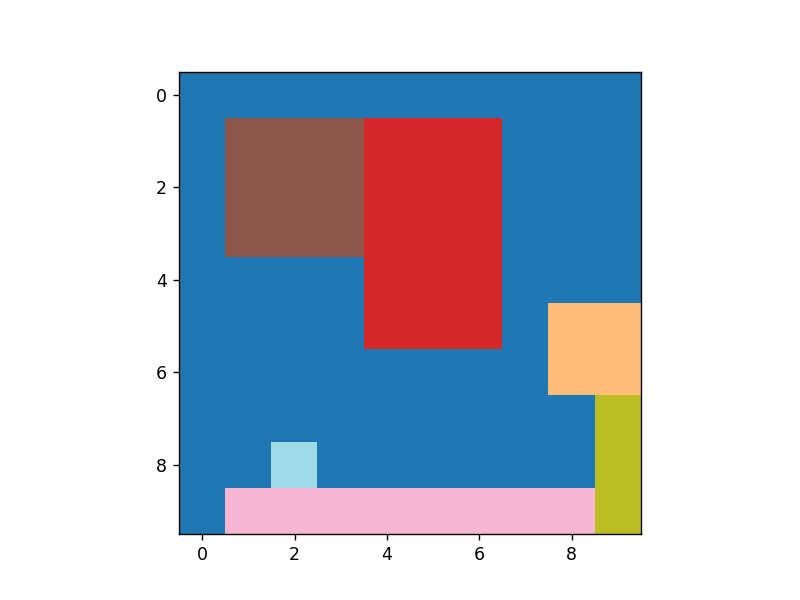

There are 32 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


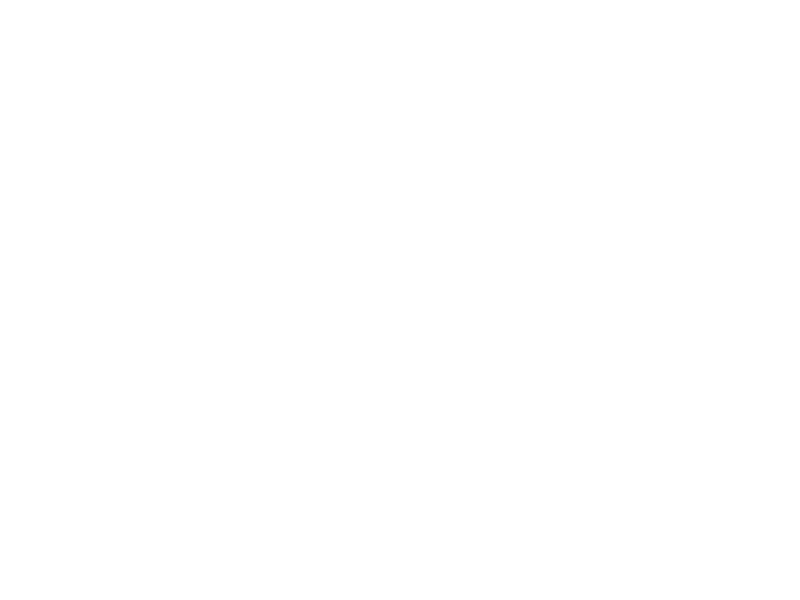

In [10]:
_,_,animation_matrix = main()
fig1 = plt.figure()
ani = animation.ArtistAnimation(fig1, animation_matrix, interval = 300, blit = True, repeat_delay = 0)

#  Finding average number of communcation towers to cover the whole area

I am using a 10x10 area. This will run the code 50 times and then take the average number of communication towers to cover the whole area. (This might take a while)

In [7]:
%%capture #makes sure this cell outputs nothing
WINDOW_SIZE = 10
num_of_comm10 = []
for i in range(50): #do this 50 times
    num_of_comm10.append(main()[0]) #append the number of rectangles used to cover a 10x10

In [8]:
avg_10 = sum(num_of_comm10)/50.
print 'It takes an average of {} communication towers to cover the 10 x 10 area'.format(sum(num_of_comm10)/50.)

It takes an average of 27.86 communication towers to cover the 10 x 10 area


What happens if we use a 20x20 area? (This also might take a while)

In [11]:
%%capture #same thing as above but with 20x20 area
WINDOW_SIZE = 20
num_of_comm20 = []
for i in range(50):
    num_of_comm20.append(main()[0])

In [12]:
avg_20 = sum(num_of_comm20)/50.
print 'It takes an average of {} communication towers to cover the 20 x 20 area'.format(avg_20)

It takes an average of 59.0 communication towers to cover the 20 x 20 area


I come to the conclusion that doubling the width and height (quadrupling the area) makes it so that it requires approximately twice the amount of communication towers to cover the whole area. This makes sense due to the fact that the rectangular coordinates are uniformly distributed so increasing the width and height also increases the range of the coordinates. The number of towers needed to fill the area is directly proportional to the window width and height.

# Average area covered per rectangle

Based on the information up above we can easily find the average area covered per rectangle. Because the size of the window can vary, I decided to represent the area per rectangle as a percentage of the whole area.

In [13]:
#take averages computed above of rectangles per whole area and divide by its respective area
print 'The average area per rectangle in the 10 x 10 window size is {}%.'.format(avg_10/(10*10)) 
print 'The average area per rectangle in the 20 x 20 window size is {}%.'.format(avg_20/(20*20))

The average area per rectangle in the 10 x 10 window size is 0.2786%.
The average area per rectangle in the 20 x 20 window size is 0.1475%.


Seeing that the average percent area covered per rectangle makes sense. We can see from the animation above that at fisrt the rectangles may be large and cover almost half the area, but near the end of the animation, various small rectangles are filling in the gaps that the larger ones didn't cover. Because there are more smaller, filler rectangles than large rectangles, it skews the average to be a lot smaller than what I expected.

# Percentage of Area Covered by n number of rectangles

Here, I am going to see plot "n" number of rectangles, see the percentage of area covered by the rectangles, increment "n" by , see the area covered again, and repeat for "n" = 5 to 20 rectangles. Hopefully, I predict that it will be a logarithmic curve where it will initially fill up the area quickly with the first rectangles and then slow down. This will be continuous with our observation that smaller rectangles will fill up the gaps left behind by the larger rectangles in the beginning.

In [15]:
%%capture
WINDOW_SIZE = 10
area_5 = [main(5)[1]/100. for i in range(20)]
area_10 = [main(10)[1]/100. for i in range(20)]
area_15 = [main(15)[1]/100. for i in range(20)]
area_20 = [main(20)[1]/100. for i in range(20)]
area_25 = [main(25)[1]/100. for i in range(20)]

<IPython.core.display.Javascript object>


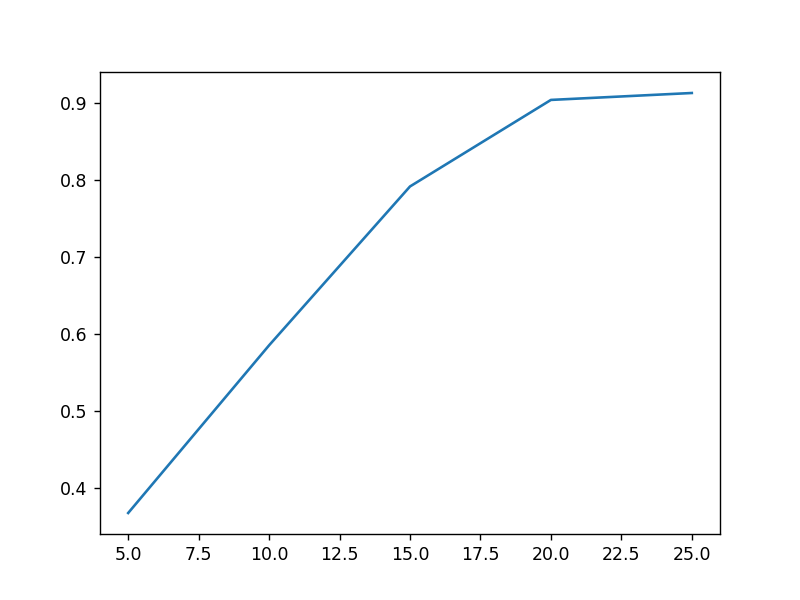

In [16]:
y = [np.mean(area_5),np.mean(area_10),np.mean(area_15),np.mean(area_20),np.mean(area_25)]
x = [5,10,15,20,25]
fig2 = plt.figure()
plt.plot(x,y)
plt.show()

This graph shows the increase in coverage vs. the number of rectangles that are covering the area. There should be a slight decrease in slope the more rectangles there are. This confirms my hypothesis that the beginning rectangles quickly cover the open space. The later rectangles cover less area since they are trimmed to fit within the notches and gaps the beginning rectangles leave behind.

Up to 10 rectangles, the percent area covered goes to ~60-80% but has diminishing returns as the number of rectangles increases. To get above ~80% covered, we will usually need 20 communication towers and to get 100% area covered, we need 25+ towers.

# Limitations

Throughout the project, there was the issue of the time it took to run the code, especially for finding the average area. Obviously, to get a better average I would have needed to execute the main() function many more times, but I only executed it 50 times to get the average number of communication towers to fill the area, and only 20 times each sample for seeing how much area a certain number of rectangles take up.

Another limitation is that the area is a square. This is a trade-off between the complexity in the code and the possibility of the different variations in area size. I decided that making area a square doesn't limit the analysis too much because the window can also vary in size but is limited to being a square. A rectangle window wouldn't be too different from a square window in terms of this problem.